<a href="https://colab.research.google.com/github/CatrixElias/AI-beam-analysis-/blob/main/Bayesian_Optimization_Laser_%2C_Orson_and_Elias_collaboration_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# everything that follows will be explained in a less abstract way in case something seems strange to you 

# a simple example of Bayesian use 

In [ ]:
try:
    # Check if notebook is running in Google Colab
    import google.colab
    # Get additional files from Github
    !wget https://raw.githubusercontent.com/krasserm/bayesian-machine-learning/dev/gaussian-processes/gaussian_processes_util.py
    # Install additional dependencies
    !pip install GPy==1.9.8
except:
    pass

Text(0, 0.5, 'Predicted')

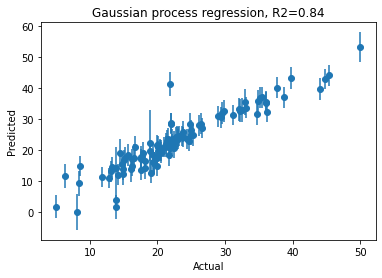

In [ ]:
from sklearn.datasets import load_breast_cancer
import warnings
warnings.filterwarnings("ignore")


# Prepare the data.
cancer = load_breast_cancer()
X = cancer["data"]
y = cancer["target"]

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
X, y = load_boston(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


from sklearn.metrics import r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

kernel = ConstantKernel(1.0) + ConstantKernel(1.0) * RBF(10)  + WhiteKernel(5)
model = GaussianProcessRegressor(kernel=kernel)

model.fit(X_train, y_train)
y_pred_tr, y_pred_tr_std = model.predict(X_train, return_std=True)
y_pred_te, y_pred_te_std = model.predict(X_test, return_std=True)

import matplotlib.pyplot as plt
plt.figure()
plt.errorbar(y_test, y_pred_te, yerr=y_pred_te_std, fmt='o')
plt.title('Gaussian process regression, R2=%.2f' % r2_score(y_test, y_pred_te))
plt.xlabel('Actual')
plt.ylabel('Predicted')

# another example of using Bayesian optimization

In [ ]:
!pip install bayesian-optimization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from bayes_opt import BayesianOptimization, UtilityFunction
import warnings
warnings.filterwarnings("ignore")


# Prepare the data.
cancer = load_breast_cancer()
X = cancer["data"]
y = cancer["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                            stratify = y,
                                        random_state = 42)


scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)# Define the black box function to optimize.


def black_box_function(C):
    # C: SVC hyper parameter to optimize for.
    model = SVC(C = C)
    model.fit(X_train_scaled, y_train)
    y_score = model.decision_function(X_test_scaled)
    f = roc_auc_score(y_test, y_score)
    return f# Set range of C to optimize for.


# bayes_opt requires this to be a dictionary.
pbounds = {"C": [0.1, 10]}# Create a BayesianOptimization optimizer,
# and optimize the given black_box_function.


optimizer = BayesianOptimization(f = black_box_function,
                                 pbounds = pbounds, verbose = 2,
                                 random_state = 4)
optimizer.maximize(init_points = 5, n_iter = 10)
print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))

|   iter    |  target   |     C     |
-------------------------------------
| 1         | 0.9979    | 9.674     |
| 2         | 0.9975    | 5.518     |
| 3         | 0.9979    | 9.73      |
| 4         | 0.9979    | 7.177     |
| 5         | 0.9979    | 7.008     |
| 6         | 0.9914    | 0.1023    |
| 7         | 0.9981    | 8.506     |
| 8         | 0.9981    | 8.15      |
| 9         | 0.9981    | 8.327     |
| 10        | 0.9981    | 8.8       |
| 11        | 0.9981    | 8.671     |
| 12        | 0.9981    | 7.974     |
| 13        | 0.9979    | 6.273     |
| 14        | 0.9981    | 8.064     |
| 15        | 0.9981    | 8.911     |
Best result: {'C': 8.505539252885074}; f(x) = 0.9981132075471698.


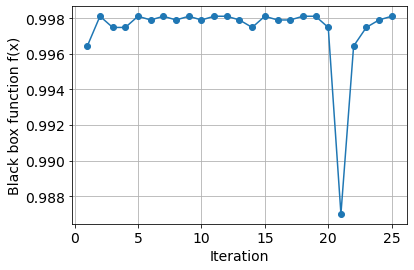

In [ ]:
# Create the optimizer. The black box function to optimize is not
# specified here, as we will call that function directly later on.
optimizer = BayesianOptimization(f = None, 
                                 pbounds = {"C": [0.01, 10], 
                                            "degree": [1, 5]}, 
                                 verbose = 2, random_state = 1234)# Specify the acquisition function (bayes_opt uses the term
# utility function) to be the upper confidence bounds "ucb".
# We set kappa = 1.96 to balance exploration vs exploitation.
# xi = 0.01 is another hyper parameter which is required in the
# arguments, but is not used by "ucb". Other acquisition functions
# such as the expected improvement "ei" will be affected by xi.


utility = UtilityFunction(kind = "ucb", kappa = 1.96, xi = 0.01)# We want to optimize both C and degree simultaneously.


def black_box_function(C, degree):
    model = SVC(C = C, degree = degree)
    model.fit(X_train_scaled, y_train)
    y_score = model.decision_function(X_test_scaled)
    f = roc_auc_score(y_test, y_score)
    return f# Optimization for loop.
for i in range(25):
    # Get optimizer to suggest new parameter values to try using the
    # specified acquisition function.
    next_point = optimizer.suggest(utility)    # Force degree from float to int.
    next_point["degree"] = int(next_point["degree"])    # Evaluate the output of the black_box_function using 
    # the new parameter values.
    target = black_box_function(**next_point)    
    try:
        # Update the optimizer with the evaluation results. 
        # This should be in try-except to catch any errors!
        optimizer.register(params = next_point, target = target)
    except:
        passprint("Best result: {}; f(x) = {:.3f}.".format(optimizer.max["params"], optimizer.max["target"]))
        plt.figure(figsize = (15, 5))


plt.plot(range(1, 1 + len(optimizer.space.target)), optimizer.space.target, "-o")
plt.grid(True)
plt.xlabel("Iteration", fontsize = 14)
plt.ylabel("Black box function f(x)", fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

# here begins our real work 



```
as soon as we have the database we adapt the code to the 

data we will have and that's it, with a preprocessing of our source 
data in a separation in model training data and model test data 
```





```
all these links correspond to source codes on the bayesian optimization pole, we will test them all and choose the one that will give the best results to publish them with Pr Antic. and all the team 
```



# [Bayesian optimization with experimental failure for high-throughput materials growth](https://www.nature.com/articles/s41524-022-00859-8)

# [code source link ]( https://github.com/nttcslab/floor-padding-BO.)

# reference source code 

#Online Bayesian Optimization for Beam Alignment in the SECAR Recoil Mass Separator [link], (https://arxiv.org/pdf/2112.01557.pdf)

[framework Gaussian process optimization](https://github.com/SheffieldML)

[additional framework python version ](https://sandipanweb.wordpress.com/2020/12/08/gaussian-process-regression-with-python/)

[additional framework matlab version ](https://github.com/gustavomalkomes)

# Automating Bayesian optimization with Bayesian optimization [link](https://proceedings.neurips.cc/paper/2018/hash/2b64c2f19d868305aa8bbc2d72902cc5-Abstract.html)

# Best Seller framework , Bayesian Optimization for ML 
[Bayesian Optimisation for Sequential Experimental
Design with Applications in Additive Manufacturing](https://arxiv.org/abs/2107.12809)

# Code and data associated with Automation and control of laser wakefield accelerators using Bayesian optimisation
[reference source code link ](https://zenodo.org/record/4229537#.Y1BZdC17RBw)

[simulation beam link python ](https://github.com/fbpic)

# article source , Optimal beam loading in a laser-plasma accelerator

! pip install laserbeamsize

[link ptyhon beam size ](https://github.com/scottprahl/laserbeamsize)





```
another example of bayesian optimization that almost all articles on laser beauty use, here I make an adaptation with lamdba 
data just to see how it works 
```



In [ ]:
!pip install gpy
!pip install nose coverage
!pip install nose

In [ ]:
!install matplotlib
!pip install seaborn 

nose.config: INFO: Ignoring files matching ['^\\.', '^_', '^setup\\.py$']


Running unit tests for GPy.testing
NumPy version 1.21.6
NumPy relaxed strides checking option: True
NumPy is installed in /usr/local/lib/python3.7/dist-packages/numpy
Python version 3.7.15 (default, Oct 12 2022, 19:14:55) [GCC 7.5.0]
nose version 1.3.7


 /usr/local/lib/python3.7/dist-packages/nose/plugins/attrib.py:242: DeprecationWarning:Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
test_flat_to_triang (GPy.testing.cython_tests.CythonTestChols) ... ok
test_triang_to_flat (GPy.testing.cython_tests.CythonTestChols) ... ok
test (GPy.testing.cython_tests.test_choleskies_backprop) ... ok
test_rect_gradx (GPy.testing.cython_tests.test_stationary) ...  /usr/local/lib/python3.7/dist-packages/paramz/parameterized.py:271: DeprecationWarning:Assigning the 'data' attribute is an inherently unsafe operation and will be removed in the future.
 /usr/local/lib/python3.7/dist-packages/paramz/parameterized.py:272: DeprecationWarning:Assigning the 'data' attribute is an inherently unsafe operation and will be removed in the future.
ok
test_rect_lengthscales (GPy.testing.cython_tests.test_stationary) ... ok
test_square_gradX (GPy.testing.cython_tests.test_s

96.0 % instances correctly classified
          |  1         |  0         | 
----------|------------|------------|
1         |  53.0      |  0         | 
0         |  4         |  43.0      | 
53.0 % instances correctly classified
          |  1         |  0         | 
----------|------------|------------|
1         |  53.0      |  0         | 
0         |  47        |  0.0       | 
54.0 % instances correctly classified
          |  1         |  0         | 
----------|------------|------------|
1         |  53.0      |  0         | 
0         |  46        |  1.0       | 


ok
test_setxy_gp (GPy.testing.gp_tests.Test) ... INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
ok
test_setxy_gplvm (GPy.testing.gp_tests.Test) ... INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
ok
test_Matern32_kernel (GPy.testing.gpy_kernels_state_space_tests.StateSpaceKernelsTests) ...  /usr/local/lib/python3.7/dist-packages/GPy/models/state_space_main.py:3357: DeprecationWarning:Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
ok
test_Matern52_kernel (GPy.testing.gpy_kernels_state_space_tests.StateSpaceKernelsTests) ... INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
ok
test_RBF_kernel (G

 /usr/local/lib/python3.7/dist-packages/GPy/inference/mcmc/samplers.py:41: DeprecationWarning:`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


ok
Check dL_dm in var_dtc is calculated correctly ... INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:sparse gp:Adding Z as parameter
ok
test_nonsym (GPy.testing.kernel_tests.Coregionalize_cython_test) ...  /usr/local/lib/python3.7/dist-packages/GPy/kern/src/coregionalize.py:91: DeprecationWarning:`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 /usr/local/lib/python3.7/dist-packages/GPy/kern/src/coregionalize.py:95: DeprecationWarning:`np.int` is a deprecated alias for the builtin `int`. To silence th

No free parameters to check
No free parameters to check
No free parameters to check
No free parameters to check
No free parameters to check
No free parameters to check


ok
test_Prod2 (GPy.testing.kernel_tests.KernelGradientTestsContinuous) ... ok
test_Prod3 (GPy.testing.kernel_tests.KernelGradientTestsContinuous) ... ok
test_Prod4 (GPy.testing.kernel_tests.KernelGradientTestsContinuous) ... ok
test_RBF (GPy.testing.kernel_tests.KernelGradientTestsContinuous) ... ok
test_RatQuad (GPy.testing.kernel_tests.KernelGradientTestsContinuous) ... ok
test_WhiteHeteroscedastic (GPy.testing.kernel_tests.KernelGradientTestsContinuous) ... ok
test_basis_func_changepoint (GPy.testing.kernel_tests.KernelGradientTestsContinuous) ... ok
test_basis_func_domain (GPy.testing.kernel_tests.KernelGradientTestsContinuous) ... ok
test_basis_func_linear_slope (GPy.testing.kernel_tests.KernelGradientTestsContinuous) ... ok
test_basis_func_poly (GPy.testing.kernel_tests.KernelGradientTestsContinuous) ... ok
test_integral (GPy.testing.kernel_tests.KernelGradientTestsContinuous) ... ok
test_integral_limits (GPy.testing.kernel_tests.KernelGradientTestsContinuous) ... ok
test_multidi

           Name            |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
-----------------------------------------------------------------------------------------------------------
 GradientChecker.X[[0]]    |   1.000000    |   0.000000    |  -21.269228   |  -21.269228   |     8e-05     
 GradientChecker.X[[1]]    |   1.000000    |   0.000000    |   -0.128057   |   -0.128057   |     5e-07     
 GradientChecker.X[[2]]    |   1.000000    |   0.000000    |   -0.074626   |   -0.074626   |     3e-07     
 GradientChecker.X[[3]]    |   1.000000    |   0.000000    |   -0.379812   |   -0.379812   |     1e-06     
           Name            |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
-----------------------------------------------------------------------------------------------------------
 GradientChecker.X[[0]]    |   1.000000    |   0.000000    |  -23.359744   |  -23.359744   |     8e-05     
 GradientChecker.X[[1]]    |

ok
test_gaussian_d2logpdf_df2_2 (GPy.testing.likelihood_tests.LaplaceTests) ... 

           Name            |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
-----------------------------------------------------------------------------------------------------------
 GradientChecker.X[[0]]    |   1.000000    |   0.000000    |  4927.644770  |  4927.644770  |     7e-07     
 GradientChecker.X[[1]]    |   1.000000    |   0.000001    |  9234.761694  |  9234.761695  |     1e-06     
 GradientChecker.X[[2]]    |   1.000000    |   0.000001    |  1424.883339  |  1424.883338  |     2e-07     
 GradientChecker.X[[3]]    |   1.000000    |   0.000002    |  5099.614131  |  5099.614129  |     8e-07     
 GradientChecker.X[[4]]    |   1.000000    |   0.000000    |  -14.520679   |  -14.520679   |     2e-09     
           Name            |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
-----------------------------------------------------------------------------------------------------------
 GradientChecker.X[[0]]    |

ok
test_laplace_log_likelihood (GPy.testing.likelihood_tests.LaplaceTests) ... INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


            Name             |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
-------------------------------------------------------------------------------------------------------------
 GradientChecker.g[[0 0]]    |   1.000000    |   0.000000    |   5.541652    |   5.541652    |     2e-06     
 GradientChecker.g[[1 0]]    |   1.000000    |   0.000000    |   5.541652    |   5.541652    |     2e-06     
Gaussian
Laplace Gaussian


ok
 /usr/local/lib/python3.7/dist-packages/GPy/testing/likelihood_tests.py:115: DeprecationWarning:`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f160406c4d0>, array([[-1.06053487], ... 

             Name              |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
---------------------------------------------------------------------------------------------------------------
 gp.sum.rbf.variance           |   1.000000    |   0.000000    |   1.978858    |   1.978858    |     2e-08     
 gp.sum.rbf.lengthscale        |   1.000000    |   0.000000    |   -1.694773   |   -1.694773   |     2e-08     
 gp.Gaussian_noise.variance    |   1.000000    |   0.000000    |   26.396268   |   26.396268   |     3e-07     
             Name              |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
---------------------------------------------------------------------------------------------------------------
 gp.sum.rbf.variance           |   1.000000    |   0.000000    |   1.978858    |   1.978858    |     2e-08     
 gp.sum.rbf.lengthscale        |   1.000000    |   0.000000    |   -1.694773   |   -1.694773   |     2e-

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f160406c4d0>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f160406c4d0>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f160406c4d0>, array([[-1.06053487], ... 

Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_logpdf
  Student_T.  |  value  |  constraints  |  priors
  t_scale2    |    0.2  |      +ve      |        
  deg_free    |    4.0  |      +ve      |        
[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_dlogpdf_df
  Student_T.  |  value  |  constraints  |  priors
  t_scale2    |    0.2  |      +ve      |        
  deg_free    |    4.0  |      +ve      |        
             Name              |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
------------------------------------

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f160406c4d0>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f160406c4d0>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f160406c4d0>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f160406c4d0>, array([[-1.06053487], ... 

 GradientChecker.g[[10  0]]    |   1.000000    |   0.000000    |   -1.846768   |   -1.846768   |     1e-07     
 GradientChecker.g[[11  0]]    |   1.000000    |   0.000000    |   -1.541055   |   -1.541055   |     1e-07     
 GradientChecker.g[[12  0]]    |   1.000000    |   0.000000    |   -1.490182   |   -1.490182   |     1e-07     
 GradientChecker.g[[13  0]]    |   1.000000    |   0.000000    |   0.842324    |   0.842324    |     7e-08     
 GradientChecker.g[[14  0]]    |   1.000000    |   0.000000    |   1.562921    |   1.562921    |     1e-07     
[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_d2logpdf_dlink2

Name : GradientChecker
Objective : -5.69516

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f160406c4d0>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f160406c4d0>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f160406c4d0>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f160406c4d0>, array([[-1.06053487], ... 

   <bound method TestNoiseModels.constrain_positive of <GPy.testing.likelihood_tests.TestNoiseModels object at 0x7f1630377150>>
parameter didn't exist
.*deg_free   <bound method TestNoiseModels.constrain_fixed of <GPy.testing.likelihood_tests.TestNoiseModels object at 0x7f1630377150>>

Name : GradientChecker
Objective : 3.003327546609801
Number of Parameters : 1
Number of Optimization Parameters : 1
Updates : True
Parameters:
  GradientChecker.  |  value  |  constraints  |  priors
  __x_t_scale2      |    0.2  |      +ve      |        
              Name               |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
-----------------------------------------------------------------------------------------------------------------
 GradientChecker.__x_t_scale2    |   1.000000    |   0.000000    |   -1.081391   |   -1.081391   |     7e-07     
              Name               |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
--

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f160406c4d0>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f160406c4d0>, array([[0.76308289, 7.79918792, 4.38409231], ... INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


   <bound method TestNoiseModels.constrain_fixed of <GPy.testing.likelihood_tests.TestNoiseModels object at 0x7f1630377150>>

Name : GradientChecker
Objective : 2.613554412309919
Number of Parameters : 1
Number of Optimization Parameters : 1
Updates : True
Parameters:
  GradientChecker.  |  value  |  constraints  |  priors
  __x_t_scale2      |    0.2  |      +ve      |        
              Name               |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
-----------------------------------------------------------------------------------------------------------------
 GradientChecker.__x_t_scale2    |   1.000000    |   0.000000    |   -0.764518   |   -0.764518   |     6e-07     
              Name               |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
-----------------------------------------------------------------------------------------------------------------
 GradientChecker.__x_t_scale2    |   1.000000    

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f1603eb7390>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f1603eb7390>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f1603eb7390>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f1603eb7390>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f1603eb7390>, array([[-1.06053487], ... 

[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_logpdf
  Student_T.  |  value  |  constraints  |  priors
  t_scale2    |    0.2  |      +ve      |        
  deg_free    |    4.0  |      +ve      |        
[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_dlogpdf_df
  Student_T.  |  value  |  constraints  |  priors
  t_scale2    |    0.2

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f1603eb7390>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f1603eb7390>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f1603eb7390>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f1603eb7390>, array([[-1.06053487], ... 

[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_d2logpdf_dlink2

Name : GradientChecker
Objective : -5.695162323891201
Number of Parameters : 15
Number of Optimization Parameters : 15
Updates : True
Parameters:
  GradientChecker.  |    value  |  constraints  |  priors
  g                 |  (15, 1)  |               |        
  Student_T.  |  value  |  constraints  |  priors
  t_scale2    |    0.2  |      +ve      |        
  deg_free    |    4.0  |      +ve      |        
             Name              |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
-------------------------------------------------------------------------------

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f1603eb7390>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f1603eb7390>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f1603eb7390>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f1603eb7390>, array([[-1.06053487], ... 

[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_dlogpdf_df_dparams
  Student_T.  |               value  |  constraints  |  priors
  t_scale2    |  0.9999993678795573  |      +ve      |        
  deg_free    |                 4.0  |      +ve      |        

StudentT likelihood: dlogpdf_df vs dlogpdf_df_dtheta
fnum: 15 dfnum: 1 f_ind: 0 fixed_val: 0
.*t_scale2   <bound method TestNoiseModels.constrain_positive of <GPy.testing.likelihood_tests.TestNoiseModels object at 0x7f1630377150>>
parameter didn't exist
.*deg_free   <bound method TestNoiseModels.constrain_fixed of <GPy.testing.likelihood_tests.TestNoiseModels object at 0x7f1630377150>>

Name : GradientChecke

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f1603eb7390>, array([[0.76308289, 7.79918792, 4.38409231], ... INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f1603ec9ad0>, array([[-1.06053487], ... 

Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_d2logpdf2_dlink2_dparams
  Student_T.  |               value  |  constraints  |  priors
  t_scale2    |  0.9999993678795573  |      +ve      |        
  deg_free    |                 4.0  |      +ve      |        

StudentT likelihood: d2logpdf_dlink2 vs d2logpdf_dlink2_dtheta
fnum: 15 dfnum: 1 f_ind: 0 fixed_val: 0
.*t_scale2   <bound method TestNoiseModels.constrain_positive of <GPy.testing.likelihood_tests.TestNoiseModels object at 0x7f1630377150>>
parameter didn't exist
.*deg_free   <bound method TestNoiseModels.constrain_fixed of <GPy.testing.likelihood_tests.TestNoiseModels object at 0x7f1630377150>>

Name : GradientChecker
Objective : 0.35991151134392685
Number of Parameters : 1
Number of Optimization Parameters : 1
Updates : True
Parameters:
  GradientChecker.  |  value  |  constraints  |  priors
  __x_t_scale2      |    1.0  

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f1603ec9ad0>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f1603ec9ad0>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f1603ec9ad0>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f1603ec9ad0>, array([[-1.06053487], ... 

[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_logpdf
  Student_T.  |  value  |  constraints  |  priors
  t_scale2    |    0.2  |      +ve      |        
  deg_free    |    4.0  |      +ve      |        
[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_dlogpdf_df
  Student_T.  |  value  |  constraints  |  priors
  t_scale2    |    0.2

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f1603ec9ad0>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f1603ec9ad0>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f1603ec9ad0>, array([[-1.06053487], ... 

[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_d2logpdf_dlink2

Name : GradientChecker
Objective : -5.695162323891201
Number of Parameters : 15
Number of Optimization Parameters : 15
Updates : True
Parameters:
  GradientChecker.  |    value  |  constraints  |  priors
  g                 |  (15, 1)  |               |        
  Student_T.  |  value  |  constraints  |  priors
  t_scale2    |    0.2  |      +ve      |        
  deg_free    |    4.0  |      +ve      |        
             Name              |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
-------------------------------------------------------------------------------

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f1603ec9ad0>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f1603ec9ad0>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f1603ec9ad0>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f1603ec9ad0>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f1603ec9ad0>, array([[-1.06053487], ... 


t_dlogpdf_dparams
  Student_T.  |  value  |  constraints  |  priors
  t_scale2    |    0.2  |      +ve      |        
  deg_free    |    4.0  |      +ve      |        

StudentT likelihood: logpdf vs dlogpdf_dtheta
fnum: 15 dfnum: 1 f_ind: 0 fixed_val: 0
.*t_scale2   <bound method TestNoiseModels.constrain_positive of <GPy.testing.likelihood_tests.TestNoiseModels object at 0x7f1630377150>>
parameter didn't exist
.*deg_free   <bound method TestNoiseModels.constrain_fixed of <GPy.testing.likelihood_tests.TestNoiseModels object at 0x7f1630377150>>

Name : GradientChecker
Objective : 12.63163660699481
Number of Parameters : 1
Number of Optimization Parameters : 1
Updates : True
Parameters:
  GradientChecker.  |  value  |  constraints  |  priors
  __x_t_scale2      |  0.001  |      +ve      |        
              Name               |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
------------------------------------------------------------------------------

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f1603ec9ad0>, array([[0.76308289, 7.79918792, 4.38409231], ... INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_d2logpdf2_dlink2_dparams
  Student_T.  |                  value  |  constraints  |  priors
  t_scale2    |  0.0009999990005003327  |      +ve      |        
  deg_free    |                    4.0  |      +ve      |        

StudentT likelihood: d2logpdf_dlink2 vs d2logpdf_dlink2_dtheta
fnum: 15 dfnum: 1 f_ind: 0 fixed_val: 0
.*t_scale2   <bound method TestNoiseModels.constrain_positive of <GPy.testing.likelihood_tests.TestNoiseModels object at 0x7f1630377150>>
parameter didn't exist
.*deg_free   <bound method TestNoiseModels.constrain_fixed of <GPy.testing.likelihood_tests.TestNoiseModels object at 0x7f1630377150

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f16040022d0>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f16040022d0>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f16040022d0>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f16040022d0>, array([[-1.06053487], ... 

[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_logpdf
  Student_T.  |  value  |  constraints  |  priors
  t_scale2    |    0.2  |      +ve      |        
  deg_free    |    4.0  |      +ve      |        
[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_dlogpdf_df
  Student_T.  |  value  |  constraints  |  priors
  t_scale2    |    0.2

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f16040022d0>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f16040022d0>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f16040022d0>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f16040022d0>, array([[-1.06053487], ... 

[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_d2logpdf_dlink2

Name : GradientChecker
Objective : -5.695162323891201
Number of Parameters : 15
Number of Optimization Parameters : 15
Updates : True
Parameters:
  GradientChecker.  |    value  |  constraints  |  priors
  g                 |  (15, 1)  |               |        
  Student_T.  |  value  |  constraints  |  priors
  t_scale2    |    0.2  |      +ve      |        
  deg_free    |    4.0  |      +ve      |        
             Name              |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
-------------------------------------------------------------------------------

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f16040022d0>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f16040022d0>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f16040022d0>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f16040022d0>, array([[-1.06053487], ... 

[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_dlogpdf_df_dparams
  Student_T.  |              value  |  constraints  |  priors
  t_scale2    |  9.999999000045399  |      +ve      |        
  deg_free    |                4.0  |      +ve      |        

StudentT likelihood: dlogpdf_df vs dlogpdf_df_dtheta
fnum: 15 dfnum: 1 f_ind: 0 fixed_val: 0
.*t_scale2   <bound method TestNoiseModels.constrain_positive of <GPy.testing.likelihood_tests.TestNoiseModels object at 0x7f1630377150>>
parameter didn't exist
.*deg_free   <bound method TestNoiseModels.constrain_fixed of <GPy.testing.likelihood_tests.TestNoiseModels object at 0x7f1630377150>>

Name : GradientChecker
O

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f16040022d0>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f16040022d0>, array([[0.76308289, 7.79918792, 4.38409231], ... INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


.*t_scale2   <bound method TestNoiseModels.constrain_positive of <GPy.testing.likelihood_tests.TestNoiseModels object at 0x7f1630377150>>
parameter didn't exist
.*deg_free   <bound method TestNoiseModels.constrain_fixed of <GPy.testing.likelihood_tests.TestNoiseModels object at 0x7f1630377150>>

Name : GradientChecker
Objective : 0.1554336600269539
Number of Parameters : 1
Number of Optimization Parameters : 1
Updates : True
Parameters:
  GradientChecker.  |  value  |  constraints  |  priors
  __x_t_scale2      |   10.0  |      +ve      |        
              Name               |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
-----------------------------------------------------------------------------------------------------------------
 GradientChecker.__x_t_scale2    |   1.000000    |   0.000000    |   -0.014917   |   -0.014917   |     2e-07     
              Name               |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_r

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f1604002750>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f1604002750>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f1604002750>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f1604002750>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f1604002750>, array([[-1.06053487], ... 

[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_logpdf
  Student_T.  |   value  |  constraints  |  priors
  t_scale2    |     0.2  |      +ve      |        
  deg_free    |  1000.0  |      +ve      |        
[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_dlogpdf_df
  Student_T.  |   value  |  constraints  |  priors
  t_scale2    |   

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f1604002750>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f1604002750>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f1604002750>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f1604002750>, array([[-1.06053487], ... 

Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_d2logpdf_dlink2

Name : GradientChecker
Objective : -16.542591591465168
Number of Parameters : 15
Number of Optimization Parameters : 15
Updates : True
Parameters:
  GradientChecker.  |    value  |  constraints  |  priors
  g                 |  (15, 1)  |               |        
  Student_T.  |   value  |  constraints  |  priors
  t_scale2    |     0.2  |      +ve      |        
  deg_free    |  1000.0  |      +ve      |        
             Name              |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
---------------------------------------------------------------------------------------------------------------
 GradientChecker.g[[0 0]]      |   1.000000    |   0.000000    |   4.708333    |   4.708333    |     6e-07     
 GradientChecker.g[[1 0]]      |   1.000000    |   0.000000    |   4.978439  

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f1604002750>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f1604002750>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f1604002750>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f1604002750>, array([[-1.06053487], ... 

[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_dlogpdf_df_dparams
  Student_T.  |                value  |  constraints  |  priors
  t_scale2    |  0.19999981873082728  |      +ve      |        
  deg_free    |               1000.0  |      +ve      |        

StudentT likelihood: dlogpdf_df vs dlogpdf_df_dtheta
fnum: 15 dfnum: 1 f_ind: 0 fixed_val: 0
.*t_scale2   <bound method TestNoiseModels.constrain_positive of <GPy.testing.likelihood_tests.TestNoiseModels object at 0x7f1630377150>>
parameter didn't exist
.*deg_free   <bound method TestNoiseModels.constrain_fixed of <GPy.testing.likelihood_tests.TestNoiseModels object at 0x7f1630377150>>

Name : GradientChe

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.student_t.StudentT object at 0x7f1604002750>, array([[0.76308289, 7.79918792, 4.38409231], ... INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.gaussian.Gaussian object at 0x7f1604002bd0>, array([[-1.06053487], ... 

[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_d2logpdf2_dlink2_dparams
  Student_T.  |                value  |  constraints  |  priors
  t_scale2    |  0.19999981873082728  |      +ve      |        
  deg_free    |               1000.0  |      +ve      |        

StudentT likelihood: d2logpdf_dlink2 vs d2logpdf_dlink2_dtheta
fnum: 15 dfnum: 1 f_ind: 0 fixed_val: 0
.*t_scale2   <bound method TestNoiseModels.constrain_positive of <GPy.testing.likelihood_tests.TestNoiseModels object at 0x7f1630377150>>
parameter didn't exist
.*deg_free   <bound method TestNoiseModels.constrain_fixed of <GPy.testing.likelihood_tests.TestNoiseModels object at 0x7f1630377150>>

Na

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.gaussian.Gaussian object at 0x7f1604002bd0>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.gaussian.Gaussian object at 0x7f1604002bd0>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.gaussian.Gaussian object at 0x7f1604002bd0>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.gaussian.Gaussian object at 0x7f1604002bd0>, array([[-1.06053487], ... 


t_logpdf
  Gaussian_noise.  |  value  |  constraints  |  priors
  variance         |    0.2  |      +ve      |        
[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_dlogpdf_df
  Gaussian_noise.  |  value  |  constraints  |  priors
  variance         |    0.2  |      +ve      |        
             Name              |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
---------------------------------------------------------------------------------------------------------------
 GradientChecker.g[[0 0]]      |   1.000000    |   0.000000    |   10.108057   |   10.108057   |     4e-07     
 GradientChecker.g[[1 0]]      |   1.000000

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.gaussian.Gaussian object at 0x7f1604002bd0>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.gaussian.Gaussian object at 0x7f1604002bd0>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.gaussian.Gaussian object at 0x7f1604002bd0>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.gaussian.Gaussian object at 0x7f1604002bd0>, array([[-1.06053487], ... 


t_d2logpdf_dlink2

Name : GradientChecker
Objective : -16.87388968803968
Number of Parameters : 15
Number of Optimization Parameters : 15
Updates : True
Parameters:
  GradientChecker.  |    value  |  constraints  |  priors
  g                 |  (15, 1)  |               |        
  Gaussian_noise.  |  value  |  constraints  |  priors
  variance         |    0.2  |      +ve      |        
             Name              |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
---------------------------------------------------------------------------------------------------------------
 GradientChecker.g[[0 0]]      |   1.000000    |   0.000000    |   5.000000    |   5.000000    |     6e-07     
 GradientChecker.g[[1 0]]      |   1.000000    |   0.000000    |   5.000000    |   5.000000    |     6e-07     
 GradientChecker.g[[2 0]]      |   1.000000    |   0.000000    |   5.000000    |   5.000000    |     6e-07     
 GradientChecker.g[[3 0]]      |   1.000000    |

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.gaussian.Gaussian object at 0x7f1604002bd0>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.gaussian.Gaussian object at 0x7f1604002bd0>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.gaussian.Gaussian object at 0x7f1604002bd0>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.gaussian.Gaussian object at 0x7f1604002bd0>, array([[-1.06053487], ... 


t_dlogpdf_df_dparams
  Gaussian_noise.  |                value  |  constraints  |  priors
  variance         |  0.19999981873082728  |      +ve      |        

Gaussian likelihood: dlogpdf_df vs dlogpdf_df_dtheta
fnum: 15 dfnum: 1 f_ind: 0 fixed_val: 0
.*variance   <bound method TestNoiseModels.constrain_positive of <GPy.testing.likelihood_tests.TestNoiseModels object at 0x7f1630377150>>

Name : GradientChecker
Objective : 6.478276399651804
Number of Parameters : 1
Number of Optimization Parameters : 1
Updates : True
Parameters:
  GradientChecker.  |  value  |  constraints  |  priors
  __x_variance      |    0.2  |      +ve      |        
              Name               |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
-----------------------------------------------------------------------------------------------------------------
 GradientChecker.__x_variance    |   1.000000    |   0.000000    |   -5.871561   |   -5.871561   |     2e-06     
          

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.gaussian.Gaussian object at 0x7f1604002bd0>, array([[0.76308289, 7.79918792, 4.38409231], ... INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.gaussian.Gaussian object at 0x7f1604002bd0>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.gaussian.Gaussian object at 0x7f1604002bd0>, array([[-1.06053487], ... 

 GradientChecker.__x_variance    |   1.000000    |   0.000000    |   -4.531731   |   -4.531731   |     2e-06     
[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_laplace_fit_rbf_white
[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_varexp
[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.gaussian.Gaussian object at 0x7f1604002bd0>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.gaussian.Gaussian object at 0x7f1603eda090>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.gaussian.Gaussian object at 0x7f1603eda090>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.gaussian.Gaussian object at 0x7f1603eda090>, array([[-1.06053487], ... 


t_dexp_dmu

Name : GradientChecker
Objective : 36.37816563730079
Number of Parameters : 15
Number of Optimization Parameters : 15
Updates : True
Parameters:
  GradientChecker.  |    value  |  constraints  |  priors
  m                 |  (15, 1)  |               |        
  Gaussian_noise.  |  value  |  constraints  |  priors
  variance         |    0.2  |      +ve      |        
             Name              |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
---------------------------------------------------------------------------------------------------------------
 GradientChecker.m[[0 0]]      |   1.000000    |   0.000000    |   6.803244    |   6.803244    |     4e-07     
 GradientChecker.m[[1 0]]      |   1.000000    |   0.000000    |   -1.728446   |   -1.728446   |     1e-07     
 GradientChecker.m[[2 0]]      |   1.000000    |   0.000000    |   -2.317225   |   -2.317225   |     1e-07     
 GradientChecker.m[[3 0]]      |   1.000000    |   0.000

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.gaussian.Gaussian object at 0x7f1603eda090>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.gaussian.Gaussian object at 0x7f1603eda090>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.gaussian.Gaussian object at 0x7f1603eda090>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.gaussian.Gaussian object at 0x7f1603eda090>, array([[-1.06053487], ... 

Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_d2logpdf_df2
  Gaussian_noise.  |  value  |  constraints  |  priors
  variance         |    0.2  |      +ve      |        
             Name              |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
---------------------------------------------------------------------------------------------------------------
 GradientChecker.g[[0 0]]      |   1.000000    |   0.000000    |   82.220485   |   82.220485   |     8e-07     
 GradientChecker.g[[1 0]]      |   1.000000    |   0.000000    |   20.565455   |   20.565455   |     2e-07     
 GradientChecker.g[[2 0]]      |   1.000000    |   0.000000    |   0.680694    |   0.680694    |     7e-09     
 GradientChecker.g[[3 0]]      |   1.000000    |   0.000000    |   36.370992   |   36.370992   |     4e-07     
 GradientChecker.g[[4 0]]      |   1.000000    |   

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.gaussian.Gaussian object at 0x7f1603eda090>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.gaussian.Gaussian object at 0x7f1603eda090>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.gaussian.Gaussian object at 0x7f1603eda090>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.gaussian.Gaussian object at 0x7f1603eda090>, array([[-1.06053487], ... 

Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_d3logpdf_dlink3

Name : GradientChecker
Objective : 75.0
Number of Parameters : 15
Number of Optimization Parameters : 15
Updates : True
Parameters:
  GradientChecker.  |    value  |  constraints  |  priors
  g                 |  (15, 1)  |               |        
  Gaussian_noise.  |  value  |  constraints  |  priors
  variance         |    0.2  |      +ve      |        
             Name              |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
---------------------------------------------------------------------------------------------------------------
 GradientChecker.g[[0 0]]      |   1.000000    |   0.000000    |   -0.000000   |   0.000000    |     0e+00     
 GradientChecker.g[[1 0]]      |   1.000000    |   0.000000    |   -0.000000   |   0.000000    |     0e+00     
 GradientChecker.g[[2 0

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.gaussian.Gaussian object at 0x7f1603eda090>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.gaussian.Gaussian object at 0x7f1603eda090>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.gaussian.Gaussian object at 0x7f1603eda090>, array([[0.76308289, 7.79918792, 4.38409231], ... INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters



t_dlogpdf_link_dparams
  Gaussian_noise.  |                value  |  constraints  |  priors
  variance         |  0.19999981873082728  |      +ve      |        

Gaussian likelihood: logpdf_link vs dlogpdf_link_dtheta
fnum: 15 dfnum: 1 f_ind: 0 fixed_val: 0
.*variance   <bound method TestNoiseModels.constrain_positive of <GPy.testing.likelihood_tests.TestNoiseModels object at 0x7f1630377150>>

Name : GradientChecker
Objective : 4.311026088016176
Number of Parameters : 1
Number of Optimization Parameters : 1
Updates : True
Parameters:
  GradientChecker.  |  value  |  constraints  |  priors
  __x_variance      |    0.2  |      +ve      |        
              Name               |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
-----------------------------------------------------------------------------------------------------------------
 GradientChecker.__x_variance    |   1.000000    |   0.000000    |   -3.350587   |   -3.350587   |     2e-06     
     

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.gaussian.Gaussian object at 0x7f1603eda090>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.gaussian.Gaussian object at 0x7f1603eda090>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.gaussian.Gaussian object at 0x7f1603eda090>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.bernoulli.Bernoulli object at 0x7f1603eda450>, array([[-1], ... 

[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_varexp
[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_dexp_dmu

Name : GradientChecker
Objective : 125.74913092768652
Number of Parameters : 15
Number of Optimization Parameters : 15
Updates : True
Parameters:
  GradientChecker.  |    value  |  constraints  |  priors
  m                

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.bernoulli.Bernoulli object at 0x7f1603eda450>, array([[-1], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.bernoulli.Bernoulli object at 0x7f1603eda450>, array([[-1], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.bernoulli.Bernoulli object at 0x7f1603eda450>, array([[-1], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.bernoulli.Bernoulli object at 0x7f1603eda450>, array([[-1], ... 

[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_logpdf
  Bernoulli.  |  value  |  constraints  |  priors
[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_dlogpdf_df
  Bernoulli.  |  value  |  constraints  |  priors
             Name              |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
----------

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.bernoulli.Bernoulli object at 0x7f1603eda450>, array([[-1], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.bernoulli.Bernoulli object at 0x7f1603eda450>, array([[-1], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.bernoulli.Bernoulli object at 0x7f1603eda450>, array([[-1], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.bernoulli.Bernoulli object at 0x7f1603eda450>, array([[-1], ... 

[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_d2logpdf_dlink2

Name : GradientChecker
Objective : -10.043925427409043
Number of Parameters : 15
Number of Optimization Parameters : 15
Updates : True
Parameters:
  GradientChecker.  |    value  |  constraints  |  priors
  g                 |  (15, 1)  |    0.0,1.0    |        
  Bernoulli.  |  value  |  constraints  |  priors
             Name              |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
---------------------------------------------------------------------------------------------------------------
 GradientChecker.g[[0 0]]      |   1.000000    |   0.000000    |  

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.bernoulli.Bernoulli object at 0x7f1603eda450>, array([[-1], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.bernoulli.Bernoulli object at 0x7f1603eda450>, array([[-1], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.bernoulli.Bernoulli object at 0x7f1603eda450>, array([[-1], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.bernoulli.Bernoulli object at 0x7f1603eda450>, array([[-1], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.bernoulli.Bernoulli object at 0x7f1603eda450>, array([[0.76308289, 7.79918792, 4.38409231], ... 

Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_dlogpdf_df_dparams
  Bernoulli.  |  value  |  constraints  |  priors

Bernoulli likelihood: dlogpdf_df vs dlogpdf_df_dtheta
[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_d2logpdf2_df2_dparams
  Bernoulli.  |  value  |  constraints  |  priors

Bernoulli likelihood: wrapper_func vs d2logpdf_df2_dtheta
[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.bernoulli.Bernoulli object at 0x7f1603eda450>, array([[0.76308289, 7.79918792, 4.38409231], ... INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.bernoulli.Bernoulli object at 0x7f1603eda450>, array([[-1], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.bernoulli.Bernoulli object at 0x7f1603eda450>, array([[-1], ... 

[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_ep_fit_rbf_white

Name : gp
Objective : 10.044741211351237
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp.                  |               value  |  constraints  |  priors
  sum.rbf.variance     |   1.293662670180383  |      +ve      |        
  sum.rbf.lengthscale  |  0.7428331016779005  |      +ve      |        
  sum.white.variance   |              0.0001  |   +ve fixed   |        
           Name            |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
---------------------------------------------------------------------------

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.bernoulli.Bernoulli object at 0x7f1603eda450>, array([[-1], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.exponential.Exponential object at 0x7f1603eda5d0>, array([[0.34627055], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.exponential.Exponential object at 0x7f1603eda5d0>, array([[0.34627055], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.exponential.Exponential object at 0x7f1603eda5d0>, array([[0.34627055], ... 


t_dexp_dmu

Name : GradientChecker
Objective : 16.498806326026973
Number of Parameters : 15
Number of Optimization Parameters : 15
Updates : True
Parameters:
  GradientChecker.  |    value  |  constraints  |  priors
  m                 |  (15, 1)  |               |        
  Bernoulli.  |  value  |  constraints  |  priors
             Name              |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
---------------------------------------------------------------------------------------------------------------
 GradientChecker.m[[0 0]]      |   1.000000    |   0.000000    |   1.068676    |   1.068676    |     1e-07     
 GradientChecker.m[[1 0]]      |   1.000000    |   0.000000    |   1.423111    |   1.423111    |     2e-07     
 GradientChecker.m[[2 0]]      |   1.000000    |   0.000000    |   0.614277    |   0.614277    |     7e-08     
 GradientChecker.m[[3 0]]      |   1.000000    |   0.000000    |   -0.964196   |   -0.964196   |     1e-07     
 Gr

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.exponential.Exponential object at 0x7f1603eda5d0>, array([[0.34627055], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.exponential.Exponential object at 0x7f1603eda5d0>, array([[0.34627055], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.exponential.Exponential object at 0x7f1603eda5d0>, array([[0.34627055], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.exponential.Exponential object at 0x7f1603eda5d0>, array([[0.34627055], ... 

Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_d2logpdf_df2
  ExpLikelihood.  |  value  |  constraints  |  priors
             Name              |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
---------------------------------------------------------------------------------------------------------------
 GradientChecker.g[[0 0]]      |   1.000000    |   0.000000    |   0.905328    |   0.905328    |     2e-07     
 GradientChecker.g[[1 0]]      |   1.000000    |   0.000000    |   5.569107    |   5.569107    |     1e-06     
 GradientChecker.g[[2 0]]      |   1.000000    |   0.000000    |   0.271216    |   0.271216    |     6e-08     
 GradientChecker.g[[3 0]]      |   1.000000    |   0.000000    |   2.258749    |   2.258749    |     5e-07     
 GradientChecker.g[[4 0]]      |   1.000000    |   0.000000    |   0.295604    |   0.295604    |     7e-08 

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.exponential.Exponential object at 0x7f1603eda5d0>, array([[0.34627055], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.exponential.Exponential object at 0x7f1603eda5d0>, array([[0.34627055], ... 

[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_d3logpdf_dlink3

Name : GradientChecker
Objective : 102.02564432485664
Number of Parameters : 15
Number of Optimization Parameters : 15
Updates : True
Parameters:
  GradientChecker.  |    value  |  constraints  |  priors
  g                 |  (15, 1)  |      +ve      |        
  ExpLikelihood.  |  value  |  constraints  |  priors
             Name              |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
---------------------------------------------------------------------------------------------------------------
 GradientChecker.g[[0 0]]      |   1.000000    |   0.000000    

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.exponential.Exponential object at 0x7f1603eda5d0>, array([[0.34627055], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.exponential.Exponential object at 0x7f1603eda5d0>, array([[0.34627055], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.exponential.Exponential object at 0x7f1603eda5d0>, array([[0.34627055], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.exponential.Exponential object at 0x7f1603eda5d0>, array([[0.34627055], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.exponential.Exponential object at 0x7f1603eda5d0>, array([[0.76308289, 7.79918792, 4.38409231], ... INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters



t_dlogpdf_df_dparams
  ExpLikelihood.  |  value  |  constraints  |  priors

Exponential likelihood: dlogpdf_df vs dlogpdf_df_dtheta
[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_d2logpdf2_df2_dparams
  ExpLikelihood.  |  value  |  constraints  |  priors

Exponential likelihood: wrapper_func vs d2logpdf_df2_dtheta
[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplac

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.poisson.Poisson object at 0x7f1603eda750>, array([[ 0.], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.poisson.Poisson object at 0x7f1603eda750>, array([[ 0.], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.poisson.Poisson object at 0x7f1603eda750>, array([[ 0.], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.poisson.Poisson object at 0x7f1603eda750>, array([[ 0.], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.poisson.Poisson object at 0x7f1603eda750>, array([[ 0.], ... 

[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_logpdf
  Poisson.  |  value  |  constraints  |  priors
[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_dlogpdf_df
  Poisson.  |  value  |  constraints  |  priors
             Name              |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
--------------

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.poisson.Poisson object at 0x7f1603eda750>, array([[ 0.], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.poisson.Poisson object at 0x7f1603eda750>, array([[ 0.], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.poisson.Poisson object at 0x7f1603eda750>, array([[ 0.], ... 

[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_d2logpdf_dlink2

Name : GradientChecker
Objective : -427.82747960656434
Number of Parameters : 15
Number of Optimization Parameters : 15
Updates : True
Parameters:
  GradientChecker.  |    value  |  constraints  |  priors
  g                 |  (15, 1)  |      +ve      |        
  Poisson.  |  value  |  constraints  |  priors
             Name              |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
---------------------------------------------------------------------------------------------------------------
 GradientChecker.g[[0 0]]      |   1.000000    |   0.000000    |   -

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.poisson.Poisson object at 0x7f1603eda750>, array([[ 0.], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.poisson.Poisson object at 0x7f1603eda750>, array([[ 0.], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.poisson.Poisson object at 0x7f1603eda750>, array([[ 0.], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.poisson.Poisson object at 0x7f1603eda750>, array([[ 0.], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.poisson.Poisson object at 0x7f1603eda750>, array([[ 0.], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.poisson.Poisson object at 0x7f1603eda750>, array([[0.76308289, 7.79918792, 4.38409231], ... 


t_dlogpdf_dparams
  Poisson.  |  value  |  constraints  |  priors

Poisson likelihood: logpdf vs dlogpdf_dtheta
[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_dlogpdf_df_dparams
  Poisson.  |  value  |  constraints  |  priors

Poisson likelihood: dlogpdf_df vs dlogpdf_df_dtheta
[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_d2logpd

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.binomial.Binomial object at 0x7f1603eda910>, array([[21], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.binomial.Binomial object at 0x7f1603eda910>, array([[21], ... 

Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_laplace_fit_rbf_white
[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_logpdf
  Binomial.  |  value  |  constraints  |  priors
[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_dlogpdf_

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.binomial.Binomial object at 0x7f1603eda910>, array([[21], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.binomial.Binomial object at 0x7f1603eda910>, array([[21], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.binomial.Binomial object at 0x7f1603eda910>, array([[21], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.binomial.Binomial object at 0x7f1603eda910>, array([[21], ... 

 GradientChecker.g[[10  0]]    |   1.000000    |   0.000000    |  -52.301534   |  -52.301534   |     4e-07     
 GradientChecker.g[[11  0]]    |   1.000000    |   0.000000    |   10.288501   |   10.288501   |     7e-08     
 GradientChecker.g[[12  0]]    |   1.000000    |   0.000000    |   7.599749    |   7.599749    |     5e-08     
 GradientChecker.g[[13  0]]    |   1.000000    |   0.000000    |   23.879748   |   23.879748   |     2e-07     
 GradientChecker.g[[14  0]]    |   1.000000    |   0.000000    |   -5.601667   |   -5.601667   |     4e-08     
[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_d2logpdf_df2
  Binomial.  |  value  |  constraints  |  prior

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.binomial.Binomial object at 0x7f1603eda910>, array([[21], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.binomial.Binomial object at 0x7f1603eda910>, array([[21], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.binomial.Binomial object at 0x7f1603eda910>, array([[21], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.binomial.Binomial object at 0x7f1603eda910>, array([[21], ... 

Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_d3logpdf_df3
  Binomial.  |  value  |  constraints  |  priors
             Name              |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
---------------------------------------------------------------------------------------------------------------
 GradientChecker.g[[0 0]]      |   1.000000    |   0.000000    |   -2.124294   |   -2.124294   |     1e-08     
 GradientChecker.g[[1 0]]      |   1.000000    |   0.000000    |   -5.082114   |   -5.082114   |     2e-08     
 GradientChecker.g[[2 0]]      |   1.000000    |   0.000000    |   4.921740    |   4.921740    |     2e-08     
 GradientChecker.g[[3 0]]      |   1.000000    |   0.000000    |   -4.773961   |   -4.773961   |     2e-08     
 GradientChecker.g[[4 0]]      |   1.000000    |   0.000000    |   1.842049    |   1.842049    |     9e-09     


ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.binomial.Binomial object at 0x7f1603eda910>, array([[21], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.binomial.Binomial object at 0x7f1603eda910>, array([[21], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.binomial.Binomial object at 0x7f1603eda910>, array([[21], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.binomial.Binomial object at 0x7f1603eda910>, array([[0.76308289, 7.79918792, 4.38409231], ... INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters




t_d2logpdf2_df2_dparams
  Binomial.  |  value  |  constraints  |  priors

Binomial likelihood: wrapper_func vs d2logpdf_df2_dtheta
[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_dlogpdf_link_dparams
  Binomial.  |  value  |  constraints  |  priors

Binomial likelihood: logpdf_link vs dlogpdf_link_dtheta
[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inferenc

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.loglogistic.LogLogistic object at 0x7f1603edaad0>, array([[0.34627055], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.loglogistic.LogLogistic object at 0x7f1603edaad0>, array([[0.34627055], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.loglogistic.LogLogistic object at 0x7f1603edaad0>, array([[0.34627055], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.loglogistic.LogLogistic object at 0x7f1603edaad0>, array([[0.34627055], ... 

[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_logpdf
  LogLogistic.  |  value  |  constraints  |  priors
  r_log_shape   |    1.0  |      +ve      |        
[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_dlogpdf_df
  LogLogistic.  |  value  |  constraints  |  priors
  r_log_shape   |    1.0  |      +ve      |        
             N

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.loglogistic.LogLogistic object at 0x7f1603edaad0>, array([[0.34627055], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.loglogistic.LogLogistic object at 0x7f1603edaad0>, array([[0.34627055], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.loglogistic.LogLogistic object at 0x7f1603edaad0>, array([[0.34627055], ... 

 GradientChecker.g[[8 0]]      |   1.000000    |   0.000000    |   -0.491831   |   -0.491831   |     5e-08     
 GradientChecker.g[[9 0]]      |   1.000000    |   0.000000    |   -0.725097   |   -0.725097   |     7e-08     
 GradientChecker.g[[10  0]]    |   1.000000    |   0.000000    |   -0.641387   |   -0.641387   |     7e-08     
 GradientChecker.g[[11  0]]    |   1.000000    |   0.000000    |   -0.150148   |   -0.150148   |     2e-08     
 GradientChecker.g[[12  0]]    |   1.000000    |   0.000000    |   0.149517    |   0.149517    |     2e-08     
 GradientChecker.g[[13  0]]    |   1.000000    |   0.000000    |   0.311367    |   0.311367    |     3e-08     
 GradientChecker.g[[14  0]]    |   1.000000    |   0.000000    |   0.064889    |   0.064889    |     7e-09     
[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0. 

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.loglogistic.LogLogistic object at 0x7f1603edaad0>, array([[0.34627055], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.loglogistic.LogLogistic object at 0x7f1603edaad0>, array([[0.34627055], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.loglogistic.LogLogistic object at 0x7f1603edaad0>, array([[0.34627055], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.loglogistic.LogLogistic object at 0x7f1603edaad0>, array([[0.34627055], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.loglogistic.LogLogistic object at 0x7f1603edaad0>, array([[0.34627055], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.loglogistic.LogLogistic object at 0x7f1603edaad0>, array([[0.34627055], ... 

 GradientChecker.g[[13  0]]    |   1.000000    |   0.000000    |   -0.005254   |   -0.005254   |     1e-10     
 GradientChecker.g[[14  0]]    |   1.000000    |   0.000000    |   -1.289631   |   -1.289631   |     3e-08     
[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_dlogpdf_dparams
  LogLogistic.  |  value  |  constraints  |  priors
  r_log_shape   |    1.0  |      +ve      |        

LogLogistic likelihood: logpdf vs dlogpdf_dtheta
[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]


ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.loglogistic.LogLogistic object at 0x7f1603edaad0>, array([[0.76308289, 7.79918792, 4.38409231], ... INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.weibull.Weibull object at 0x7f1603edae10>, array([[0.34627055], ... 

Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_d2logpdf2_dlink2_dparams
  LogLogistic.  |  value  |  constraints  |  priors
  r_log_shape   |    1.0  |      +ve      |        

LogLogistic likelihood: d2logpdf_dlink2 vs d2logpdf_dlink2_dtheta
[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_laplace_fit_rbf_white


ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.weibull.Weibull object at 0x7f1603edae10>, array([[0.34627055], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.weibull.Weibull object at 0x7f1603edae10>, array([[0.34627055], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.weibull.Weibull object at 0x7f1603edae10>, array([[0.34627055], ... 

[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_logpdf
  Weibull.         |  value  |  constraints  |  priors
  r_weibull_shape  |    1.0  |      +ve      |        
[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_dlogpdf_df
  Weibull.         |  value  |  constraints  |  priors
  r_weibull_shape  |    1.0  |      +ve      |        
  

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.weibull.Weibull object at 0x7f1603edae10>, array([[0.34627055], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.weibull.Weibull object at 0x7f1603edae10>, array([[0.34627055], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.weibull.Weibull object at 0x7f1603edae10>, array([[0.34627055], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.weibull.Weibull object at 0x7f1603edae10>, array([[0.34627055], ... 

 GradientChecker.g[[13  0]]    |   1.000000    |   0.000000    |   0.393594    |   0.393594    |     3e-08     
 GradientChecker.g[[14  0]]    |   1.000000    |   0.000000    |   0.118423    |   0.118423    |     8e-09     
[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_d2logpdf_dlink2

Name : GradientChecker
Objective : -99.18437982499727
Number of Parameters : 15
Number of Optimization Parameters : 15
Updates : True
Parameters:
  GradientChecker.  |    value  |  constraints  |  priors
  g                 |  (15, 1)  |      +ve      |        
  Weibull.         |  value  |  constraints  |  priors
  r_weibull_shape  |    1.0  |      +ve      |        
       

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.weibull.Weibull object at 0x7f1603edae10>, array([[0.34627055], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.weibull.Weibull object at 0x7f1603edae10>, array([[0.34627055], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.weibull.Weibull object at 0x7f1603edae10>, array([[0.34627055], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.weibull.Weibull object at 0x7f1603edae10>, array([[0.34627055], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.weibull.Weibull object at 0x7f1603edae10>, array([[0.34627055], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.weibull.Weibull object at 0x7f1603edae10>, array([[0.76308289, 7.79918792, 4.38409231], ... 


t_dlogpdf_dparams
  Weibull.         |  value  |  constraints  |  priors
  r_weibull_shape  |    1.0  |      +ve      |        

Weibull likelihood: logpdf vs dlogpdf_dtheta
[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_dlogpdf_df_dparams
  Weibull.         |  value  |  constraints  |  priors
  r_weibull_shape  |    1.0  |      +ve      |        

Weibull likelihood: dlogpdf_df vs dlogpdf_df_dtheta
[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not imple

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.multioutput_likelihood.MultioutputLikelihood object at 0x7f1603e61790>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.multioutput_likelihood.MultioutputLikelihood object at 0x7f1603e61790>, array([[-1.06053487], ... 


t_laplace_fit_rbf_white
[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_logpdf
  multioutput_likelihood.  |  value  |  constraints  |  priors
  Gaussian_noise.variance  |    1.0  |      +ve      |        
[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_dlogpdf_df
  multioutput_likelihood.  |  value  |  constraints  |  priors
  Gaussi

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.multioutput_likelihood.MultioutputLikelihood object at 0x7f1603e61790>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.multioutput_likelihood.MultioutputLikelihood object at 0x7f1603e61790>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.multioutput_likelihood.MultioutputLikelihood object at 0x7f1603e61790>, array([[-1.06053487], ... 

 GradientChecker.g[[9 0]]      |   1.000000    |   0.000000    |   -0.002235   |   -0.002235   |     2e-10     
 GradientChecker.g[[10  0]]    |   1.000000    |   0.000000    |   -1.828724   |   -1.828724   |     2e-07     
 GradientChecker.g[[11  0]]    |   1.000000    |   0.000000    |   -0.397794   |   -0.397794   |     4e-08     
 GradientChecker.g[[12  0]]    |   1.000000    |   0.000000    |   0.641036    |   0.641036    |     7e-08     
 GradientChecker.g[[13  0]]    |   1.000000    |   0.000000    |   -0.239316   |   -0.239316   |     3e-08     
 GradientChecker.g[[14  0]]    |   1.000000    |   0.000000    |   0.979721    |   0.979721    |     1e-07     
[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not 

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.multioutput_likelihood.MultioutputLikelihood object at 0x7f1603e61790>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.multioutput_likelihood.MultioutputLikelihood object at 0x7f1603e61790>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.multioutput_likelihood.MultioutputLikelihood object at 0x7f1603e61790>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.multioutput_likelihood.MultioutputLikelihood object at 0x7f1603e61790>, array([[-1.06053487], ... 


 GradientChecker.g[[4 0]]      |   1.000000    |   0.000000    |   0.236223    |   0.236223    |     3e-06     
 GradientChecker.g[[5 0]]      |   1.000000    |   0.000000    |   0.314587    |   0.314587    |     4e-06     
 GradientChecker.g[[6 0]]      |   1.000000    |   0.000000    |   0.496379    |   0.496379    |     6e-06     
 GradientChecker.g[[7 0]]      |   1.000000    |   0.000000    |   0.017826    |   0.017826    |     2e-07     
 GradientChecker.g[[8 0]]      |   1.000000    |   0.000000    |   0.502023    |   0.502023    |     6e-06     
 GradientChecker.g[[9 0]]      |   1.000000    |   0.000000    |   1.014270    |   1.014270    |     1e-05     
 GradientChecker.g[[10  0]]    |   1.000000    |   0.000000    |   3.934799    |   3.934799    |     4e-05     
 GradientChecker.g[[11  0]]    |   1.000000    |   0.000000    |   0.481353    |   0.481353    |     5e-06     
 GradientChecker.g[[12  0]]    |   1.000000    |   0.000000    |   0.772351    |   0.772351    |     9e

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.multioutput_likelihood.MultioutputLikelihood object at 0x7f1603e61790>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.multioutput_likelihood.MultioutputLikelihood object at 0x7f1603e61790>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.multioutput_likelihood.MultioutputLikelihood object at 0x7f1603e61790>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.multioutput_likelihood.MultioutputLikelihood object at 0x7f1603e61790>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.multioutput_likelihood.MultioutputLikelihood object at 0x7f1603e61790>, array([[0.76308289, 7.79918792, 4.38409231], ... 

[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_dlogpdf_df_dparams
  multioutput_likelihood.  |  value  |  constraints  |  priors
  Gaussian_noise.variance  |    1.0  |      +ve      |        

MultioutputLikelihood likelihood: dlogpdf_df vs dlogpdf_df_dtheta
[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_d2logpdf2_df2_dparams
  mult

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.multioutput_likelihood.MultioutputLikelihood object at 0x7f1603e61790>, array([[0.76308289, 7.79918792, 4.38409231], ... INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters



t_laplace_fit_rbf_white
[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_ep_fit_rbf_white

Name : gp
Objective : 15.775673273995624
Number of Parameters : 4
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                                             |               value  |  constraints  |  priors
  sum.rbf.variance                                |   1.293662670180383  |      +ve      |        
  sum.rbf.lengthscale                             |  0.7428331016779005  |      +ve      |        
  sum.white.variance                              |              0.0001  |   +ve fixed   |        
  multioutput_likelihood.Gaussian_noise.variance  

ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.multioutput_likelihood.MultioutputLikelihood object at 0x7f1603e61790>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.multioutput_likelihood.MultioutputLikelihood object at 0x7f1603e61790>, array([[-1.06053487], ... ok
GPy.testing.likelihood_tests.TestNoiseModels.test_scale2_models(<GPy.likelihoods.multioutput_likelihood.MultioutputLikelihood object at 0x7f1603e61790>, array([[-1.06053487], ... 

[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_varexp
[[-1.06053487]
 [ 1.15645752]
 [ 0.01980117]
 [ 0.1496075 ]
 [-0.74031556]
 [ 0.46249986]
 [ 0.67049807]
 [ 0.06033794]
 [ 0.56408535]
 [ 0.15887518]
 [ 1.        ]
 [ 1.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]]
Warning, Exact inference is not implemeted for non-identity link functions,            if you are not already, ensure Laplace inference_method is used

t_dexp_dmu

Name : GradientChecker
Objective : 17.213576472630958
Number of Parameters : 15
Number of Optimization Parameters : 15
Updates : True
Parameters:
  GradientChecker.  |    value  |  constraints  |  priors
  m                

ok
test_einsum_ij_jlk_to_ilk (GPy.testing.linalg_test.LinalgTests) ... ok
test_einsum_ijk_ljk_to_ilk (GPy.testing.linalg_test.LinalgTests) ... ok
test_jitchol_failure (GPy.testing.linalg_test.LinalgTests) ... ok
Expect 5 rounds of jitter to be added and for the recovered matrix to be ... ok
test_trace_dot (GPy.testing.linalg_test.LinalgTests) ... ok
test_Cloglog_gradients (GPy.testing.link_function_tests.LinkFunctionTests) ... ok
test_Log_ex_1_gradients (GPy.testing.link_function_tests.LinkFunctionTests) ... ok
test_identity_gradients (GPy.testing.link_function_tests.LinkFunctionTests) ... 

 GradientChecker.v[[2 0]]      |   1.000000    |   0.000000    |   0.248834    |   0.248834    |     2e-08     
 GradientChecker.v[[3 0]]      |   1.000000    |   0.000000    |   0.229032    |   0.229032    |     2e-08     
 GradientChecker.v[[4 0]]      |   1.000000    |   0.000000    |   0.208027    |   0.208027    |     1e-08     
 GradientChecker.v[[5 0]]      |   1.000000    |   0.000000    |   0.594488    |   0.594488    |     4e-08     
 GradientChecker.v[[6 0]]      |   1.000000    |   0.000000    |   0.519906    |   0.519906    |     4e-08     
 GradientChecker.v[[7 0]]      |   1.000000    |   0.000000    |   0.456503    |   0.456503    |     3e-08     
 GradientChecker.v[[8 0]]      |   1.000000    |   0.000000    |   0.404445    |   0.404445    |     3e-08     
 GradientChecker.v[[9 0]]      |   1.000000    |   0.000000    |   0.366134    |   0.366134    |     3e-08     
 GradientChecker.v[[10  0]]    |   1.000000    |   0.000000    |   0.055121    |   0.055121    |     4e-

ok
test_log_ex_1_overflow (GPy.testing.link_function_tests.LinkFunctionTests) ... ok
test_log_gradients (GPy.testing.link_function_tests.LinkFunctionTests) ... ok
test_log_overflow (GPy.testing.link_function_tests.LinkFunctionTests) ... ok
test_probit_gradients (GPy.testing.link_function_tests.LinkFunctionTests) ... ok
test_reciprocal_gradients (GPy.testing.link_function_tests.LinkFunctionTests) ... ok
test_addmapping (GPy.testing.mapping_tests.MappingTests) ... ok
test_compoundmapping (GPy.testing.mapping_tests.MappingTests) ... 

         Name         |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
------------------------------------------------------------------------------------------------------
 GradientChecker.X    |   1.000000    |   0.000000    |   -1.000000   |   -1.000000   |     4e-07     
         Name         |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
------------------------------------------------------------------------------------------------------
 GradientChecker.X    |   1.000000    |   0.000000    |   -0.000000   |   0.000000    |     0e+00     
         Name         |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
------------------------------------------------------------------------------------------------------
 GradientChecker.X    |   1.000000    |   0.000000    |   -0.000000   |   0.000000    |     1e+00     
         Name         |     Ratio     |  Difference   |  Analytical   |  

ok
test_kernelmapping (GPy.testing.mapping_tests.MappingTests) ... ok
test_linearmapping (GPy.testing.mapping_tests.MappingTests) ... ok
test_mlpextmapping (GPy.testing.mapping_tests.MappingTests) ... ok
test_mlpmapping (GPy.testing.mapping_tests.MappingTests) ... ok
A linear mean function with parameters that we'll learn alongside the kernel ... INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
ok
A linear mean function with parameters that we'll learn alongside the kernel ... INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
ok
A linear mean function with parameters that we'll learn alongside the kernel ... INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
ok
The simplest possible mean function. No parameters, just a simple Sinusoid. ... INFO:GP:initializing Y
INFO:GP:initializing inference method
INF

defaulting to  <GPy.inference.latent_function_inference.var_dtc.VarDTC object at 0x7f1603bec550> for latent function inference


SKIP: climin not installed, skipping stochastic gradients
test_safe_exp_lower (GPy.testing.misc_tests.MiscTests) ... ok
test_safe_exp_upper (GPy.testing.misc_tests.MiscTests) ... ok
Testing GPLVM with rbf + bias kernel ... INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
ok
Testing GPLVM with rbf + bias kernel ... 

1


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
ok
Testing GPLVM with rbf + bias kernel ... INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
ok
Testing the GP regression with bias kernel on 1d data ... INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
ok
Testing the GP regression with bias kernel on 2d data ... INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
ok
Testing the GP regression with exponential kernel on 1d data ... INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
ok
Testing the GP regression with exponential kernel on 2d data ... INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
ok
Testing the GP regressi

Intializing with GP...
Fit Sparse GP...


INFO:BayesianGPLVM:initializing latent space X with method PCA
INFO:BayesianGPLVM:initializing latent space variance ~ uniform(0,.1)
INFO:BayesianGPLVM:initializing inducing inputs
DEBUG:BayesianGPLVM:creating inference_method var_dtc
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:sparse gp:Adding Z as parameter


Fit BGPLVM...


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:sparse gp:Adding Z as parameter


Done.


 /usr/local/lib/python3.7/dist-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning:Passing unrecognized arguments to super(HTML).__init__(width='100%').
object.__init__() takes exactly one argument (the instance to initialize)
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
 /usr/local/lib/python3.7/dist-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning:Passing unrecognized arguments to super(VBox).__init__(padding=2, width='40%').
object.__init__() takes exactly one argument (the instance to initialize)
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
 /usr/local/lib/python3.7/dist-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning:Passing unrecognized arguments to super(Box).__init__(padding=2, width='60%').
object.__init__() takes exactly one argument (the instance to initialize)
This is deprecated in traitlets 4.2.This error will be raised in a future rele

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:sparse gp:Adding Z as parameter


ok
test_multiout_regression_md (GPy.testing.model_tests.GradientTests) ...  /usr/local/lib/python3.7/dist-packages/GPy/testing/model_tests.py:1122: DeprecationWarning:`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 /usr/local/lib/python3.7/dist-packages/GPy/testing/model_tests.py:1123: DeprecationWarning:`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to 

Intializing with GP...
Fit Sparse GP...
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why

INFO:BayesianGPLVM:initializing latent space X with method PCA
INFO:BayesianGPLVM:initializing latent space variance ~ uniform(0,.1)
INFO:BayesianGPLVM:initializing inducing inputs
DEBUG:BayesianGPLVM:creating inference_method var_dtc
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:sparse gp:Adding Z as parameter


why are your arrays not F order?
why are your arrays not F order?
Fit BGPLVM...


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:sparse gp:Adding Z as parameter


Done.


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:sparse gp:Adding Z as parameter


ok
test_multioutput_regression_1D (GPy.testing.model_tests.GradientTests) ... INFO:GP:initializing Y
 /usr/local/lib/python3.7/dist-packages/GPy/core/gp.py:87: UserWarning:Your kernel has a different input dimension 1 then the given X dimension 2. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
ok
test_multioutput_sparse_regression_1D (GPy.testing.model_tests.GradientTests) ...  /usr/local/lib/python3.7/dist-packages/GPy/models/sparse_gp_coregionalized_regression.py:56: DeprecationWarning:`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprec


Name : manifold relevance determination
Objective : 15598.386363442738
Number of Parameters : 651
Number of Optimization Parameters : 51
Updates : True
Parameters:
  manifold_relevance_determination.  |    value  |  constraints  |  priors
  latent_space.mean                  |  (60, 5)  |     fixed     |        
  latent_space.variance              |  (60, 5)  |   +ve fixed   |        
  inducing_inputs                    |   (6, 5)  |               |        
  Y0.sum.linear.variances            |     (5,)  |      +ve      |        
  Y0.sum.white.variance              |   0.0001  |      +ve      |        
  Y0.Gaussian_noise.variance         |    0.025  |      +ve      |        
  Y1.sum.linear.variances            |     (5,)  |      +ve      |        
  Y1.sum.white.variance              |   0.0001  |      +ve      |        
  Y1.Gaussian_noise.variance         |    0.025  |      +ve      |        
  Y2.sum.linear.variances            |     (5,)  |      +ve      |        
  Y2.sum.w

INFO:MRD:working on im <0x7f1603b508d0>
INFO:MRD:working on im <0x7f1603b50e10>
INFO:MRD:working on im <0x7f1603c5cd50>
INFO:MRD:working on im <0x7f1603b508d0>
INFO:MRD:working on im <0x7f1603b50e10>
INFO:MRD:working on im <0x7f1603c5cd50>
INFO:MRD:working on im <0x7f1603b508d0>
INFO:MRD:working on im <0x7f1603b50e10>
INFO:MRD:working on im <0x7f1603c5cd50>
INFO:MRD:working on im <0x7f1603b508d0>
INFO:MRD:working on im <0x7f1603b50e10>
INFO:MRD:working on im <0x7f1603c5cd50>
INFO:MRD:working on im <0x7f1603b508d0>
INFO:MRD:working on im <0x7f1603b50e10>
INFO:MRD:working on im <0x7f1603c5cd50>
INFO:MRD:working on im <0x7f1603b508d0>
INFO:MRD:working on im <0x7f1603b50e10>
INFO:MRD:working on im <0x7f1603c5cd50>



Name : manifold relevance determination
Objective : 15598.386363446696
Number of Parameters : 651
Number of Optimization Parameters : 651
Updates : True
Parameters:
  manifold_relevance_determination.  |                  value  |  constraints  |  priors
  latent_space.mean                  |                (60, 5)  |               |        
  latent_space.variance              |                (60, 5)  |      +ve      |        
  inducing_inputs                    |                 (6, 5)  |               |        
  Y0.sum.linear.variances            |                   (5,)  |      +ve      |        
  Y0.sum.white.variance              |  9.999999999999999e-05  |      +ve      |        
  Y0.Gaussian_noise.variance         |   0.025000000000000005  |      +ve      |        
  Y1.sum.linear.variances            |                   (5,)  |      +ve      |        
  Y1.sum.white.variance              |  9.999999999999999e-05  |      +ve      |        
  Y1.Gaussian_noise.variance     

INFO:MRD:working on im <0x7f1603b508d0>
INFO:MRD:working on im <0x7f1603b50e10>
INFO:MRD:working on im <0x7f1603c5cd50>
INFO:MRD:working on im <0x7f1603b508d0>
INFO:MRD:working on im <0x7f1603b50e10>
INFO:MRD:working on im <0x7f1603c5cd50>
INFO:MRD:working on im <0x7f1603b508d0>
INFO:MRD:working on im <0x7f1603b50e10>
INFO:MRD:working on im <0x7f1603c5cd50>
INFO:MRD:working on im <0x7f1603b508d0>
INFO:MRD:working on im <0x7f1603b50e10>
INFO:MRD:working on im <0x7f1603c5cd50>
ok
A InputWarpedGP with the identity warping function should be ... INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters



Name : manifold relevance determination
Objective : 15598.386363446696
Number of Parameters : 651
Number of Optimization Parameters : 651
Updates : True
Parameters:
  manifold_relevance_determination.  |                  value  |  constraints  |  priors
  latent_space.mean                  |                (60, 5)  |               |        
  latent_space.variance              |                (60, 5)  |      +ve      |        
  inducing_inputs                    |                 (6, 5)  |               |        
  Y0.sum.linear.variances            |                   (5,)  |      +ve      |        
  Y0.sum.white.variance              |  9.999999999999999e-05  |      +ve      |        
  Y0.Gaussian_noise.variance         |   0.025000000000000005  |      +ve      |        
  Y1.sum.linear.variances            |                   (5,)  |      +ve      |        
  Y1.sum.white.variance              |  9.999999999999999e-05  |      +ve      |        
  Y1.Gaussian_noise.variance     

ok
test_kumar_warping_gradient (GPy.testing.model_tests.MiscTests) ... WARNING:a0:reconstraining parameters a0
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
 /usr/local/lib/python3.7/dist-packages/GPy/testing/model_tests.py:463: DeprecationWarning:Please use assertEqual instead.
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
 /usr/local/lib/python3.7/dist-packages/GPy/testing/model_tests.py:469: DeprecationWarning:Please use assertEqual instead.
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
 /usr/local/lib/python3.7/dist-packages/GPy/testing/model_tests.py:475: DeprecationWarning:Please use assertEqual instead.
ok
test_kumar_warping_parameters (GPy.testing.model_tests.MiscTests) ...  /usr/local/lib/python3.7/dist-packages/GPy/testing/model_tests.py:486: DeprecationWarning:Please use assertRai


Name : GP regression
Objective : -21.857296787999886
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |   0.9620908988081452  |      +ve      |        
  rbf.lengthscale          |   1.8671800720796496  |      +ve      |        
  Gaussian_noise.variance  |  0.00120172962055399  |      +ve      |        

Name : GP regression
Objective : -12.679148998281626
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  rbf.variance             |      1.183175836959704  |      +ve      |        
  rbf.lengthscale          |     1.8982005395050812  |      +ve      |        
  Gaussian_noise.variance  |  0.0034655916487624254  |      +ve      |        


INFO:MRD:init done
INFO:MRD:working on im <0x7f16038fec10>
INFO:MRD:working on im <0x7f16038fe810>
 /usr/local/lib/python3.7/dist-packages/GPy/testing/model_tests.py:419: DeprecationWarning:Please use assertEqual instead.
 /usr/local/lib/python3.7/dist-packages/GPy/testing/model_tests.py:421: DeprecationWarning:Please use assertEqual instead.
 /usr/local/lib/python3.7/dist-packages/GPy/testing/model_tests.py:423: DeprecationWarning:Please use assertEqual instead.
INFO:MRD:working on im <0x7f16038fec10>
INFO:MRD:working on im <0x7f16038fe810>
 /usr/local/lib/python3.7/dist-packages/GPy/testing/model_tests.py:425: DeprecationWarning:Please use assertEqual instead.
ok
test_mrd (GPy.testing.model_tests.MiscTests) ... DEBUG:MRD:creating observable arrays
INFO:MRD:building kernels
INFO:MRD:adding X and Z
INFO:MRD:initializing latent space variance ~ uniform(0,.1)
INFO:MRD:initializing kernel RBF
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
ok
test_normalizer (GPy.testing.model_tests.MiscTests) ... INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
ok
test_offset_regression (GPy.testing.model_tests.MiscTests) ... INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
ok
test_posterior_inf_basis_funcs (GPy.testing.model_tests.MiscTests) ... INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
ok
Projection of Gaussian through a linear function is still gaussian, and moments are analytical to compute, so we can check this case for predictions easily ... INFO:BayesianGPLVM:initializing latent space variance ~ uniform(0,.1)
INFO:BayesianGPLVM:initializing inducing inputs
DEBUG:BayesianGPLVM:creating inference_method var_dtc
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:sparse gp:Adding Z as parameter
ok
test_raw_predict (GPy.testing.model_t

Optimization restart 1/5, f = -42.29175217531284
Optimization restart 2/5, f = -122.98080481266106
Optimization restart 3/5, f = 3.528940629250032
Optimization restart 4/5, f = -123.14863486688824


 /usr/local/lib/python3.7/dist-packages/GPy/util/warping_functions.py:142: RuntimeWarning:overflow encountered in cosh
 /usr/local/lib/python3.7/dist-packages/GPy/util/warping_functions.py:143: RuntimeWarning:overflow encountered in cosh
 /usr/local/lib/python3.7/dist-packages/GPy/util/warping_functions.py:144: RuntimeWarning:overflow encountered in cosh
 /usr/local/lib/python3.7/dist-packages/GPy/util/warping_functions.py:152: RuntimeWarning:overflow encountered in cosh
 /usr/local/lib/python3.7/dist-packages/GPy/util/warping_functions.py:153: RuntimeWarning:overflow encountered in cosh


Optimization restart 5/5, f = -124.10162711644517


 /usr/local/lib/python3.7/dist-packages/GPy/plotting/gpy_plot/plot_util.py:75: DeprecationWarning:`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
ok
A WarpedGP with the identity warping function should be ... INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
ok
A WarpedGP with the log warp

ok
test_pep_1d_gradients (GPy.testing.pep_tests.PEPgradienttest) ... INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:sparse gp:Adding Z as parameter
ok
test_pep_2d_gradients (GPy.testing.pep_tests.PEPgradienttest) ... INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:sparse gp:Adding Z as parameter
ok
test_pep_fitc_consistency (GPy.testing.pep_tests.PEPgradienttest) ... INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:sparse gp:Adding Z as parameter
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:sparse gp:Adding Z as parameter
ok
test_pep_vfe_consistency (GPy.testing.pep_tests.PEPgradienttest) ... INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:spar

Array with ID[139732529398096] at indices [ 0  4  4  4  5  6  6  7  7  7  9 10 10 11 11 12 12 13 13 14 14 15 15 18
 19 20 21 21 22 23] have not finite values: [[-0.72621349         nan  0.0513161  -1.15771947]
 [ 0.02961015         nan         nan         nan]
 [ 0.02961015         nan         nan         nan]
 [ 0.02961015         nan         nan         nan]
 [ 0.58496974  0.15267657 -1.56565729         nan]
 [-0.03266414         nan -0.48257265         nan]
 [-0.03266414         nan -0.48257265         nan]
 [ 1.09539006         nan         nan         nan]
 [ 1.09539006         nan         nan         nan]
 [ 1.09539006         nan         nan         nan]
 [-1.02248698 -0.40282692  0.22048686         nan]
 [        nan -1.64898482         nan -1.16683222]
 [        nan -1.64898482         nan -1.16683222]
 [        nan  0.70211017 -0.2745692          nan]
 [        nan  0.70211017 -0.2745692          nan]
 [        nan -0.60654513 -0.41706441         nan]
 [        nan -0.60654513

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as par

AssertionError: ignored

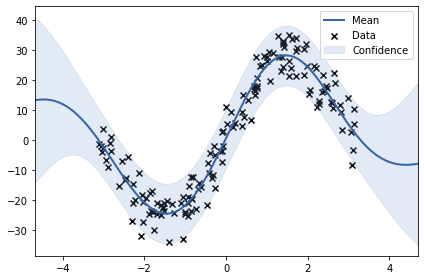

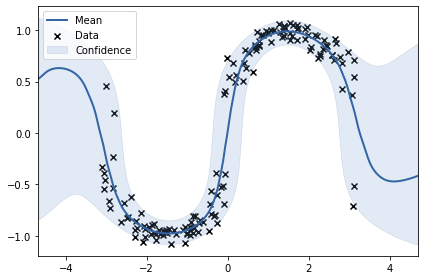

In [ ]:
# let X, Y be data loaded above
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Prepare the data.

import matplotlib.pyplot as plt
import seaborn as sns 

cancer = load_breast_cancer()
X = cancer["data"]
y = cancer["target"]

import GPy ;GPy.tests()

# Model creation:
m = GPy.models.GPRegression(X, y)
m.optimize()

# 1: Saving a model:
np.save('model_save.npy', m.param_array)

# 2: loading a model
# Model creation, without initialization:
m_load = GPy.models.GPRegression(X, y, initialize=False)

m_load.update_model(False) # do not call the underlying expensive algebra on load
m_load.initialize_parameter() # Initialize the parameters (connect the parameters up)

m_load[:] = np.load('model_save.npy') # Load the parameters
m_load.update_model(True) # Call the algebra only once
print(m_load)